In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio
import os
import time

from tqdm import tqdm

import sys
sys.path.append("../")
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

import sys
sys.path.append("../")
from pyfiles.dataset import Parallelo2oVCMelDataset, ParallelArcticDataset
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import numpy as np
import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

sys.path.append("../../hifi-gan/")
import configparser
import json
from env import AttrDict
from meldataset import MAX_WAV_VALUE, MelDataset, get_dataset_filelist, mel_spectrogram
from models import Generator
from train import load_checkpoint, scan_checkpoint

In [4]:
setup = 0

if setup==0: ### Accent Addition
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"
    # src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/BDL/"
    # trg_dir = "/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/BDL/ASI/"
elif setup==1: ### Accent Removal
    # cosyvoice
    # src_dir = f"/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/ASI/"
    # trg_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/ASI/English/"
    # elevenlabs
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
elif setup==2: ### Speaker Voice conversion
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/BDL/"
if setup==3: ### Accent Addition (Korean)
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Korean/"

scaler = {}
scaler_filename = f"ckpts/scalers/LibriTTS-R_80mel.save"
scaler["80mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_hifiganmel.save"
scaler["hifiganmel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_16000.save"
scaler["mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_wavlm.save"
scaler["wavlm"] = joblib.load(scaler_filename)

dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "test", input_output=["hifiganmel", "hifiganmel"], noembedding=True)
# dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "train", input_output=["mel", "mel"], noembedding=True)

### Vocoder Preparation ###
class HiFiGAN():
    def __init__(self, checkpoing_file):
        scaler = None
        try:
            if int(os.path.dirname(checkpoint_file)[-1]) in [4, 5, 6]:
                import joblib
                scaler_filename = f"ckpts/scalers/LibriTTS-R_hifiganmel.save"
                scaler = joblib.load(scaler_filename)
        except ValueError:
            pass

        config_file = os.path.join(os.path.split(checkpoint_file)[0], 'config.json')
        with open(config_file) as f:
            data = f.read()
        global h
        json_config = json.loads(data)
        h = AttrDict(json_config)

        torch.manual_seed(h.seed)
        global device
        if torch.cuda.is_available():
            torch.cuda.manual_seed(h.seed)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        generator = Generator(h).to(device)
        state_dict_g = load_checkpoint(checkpoint_file, device)
        generator.load_state_dict(state_dict_g['generator'])
        generator.eval()
        generator.remove_weight_norm()
        self.generator = generator
        self.h = h
    
    def get(self, melarray):
        mel = torch.from_numpy(melarray.T).unsqueeze(0).to(device)
        wav = vocoder.generator(transform(mel).to(mel.dtype))
        wav = (wav.squeeze()*MAX_WAV_VALUE).detach().cpu().numpy().astype('int16')
        return wav
feat = "hifiganmel"
def transform(x):
    mean_ = torch.tensor(scaler[feat].mean_.reshape(1, -1, 1)).to(x.device)
    scale_ = torch.tensor(scaler[feat].scale_.reshape(1, -1, 1)).to(x.device)
    return (x-mean_)/scale_
def inverse_transform(x):
    mean_ = torch.tensor(scaler[feat].mean_.reshape(1, -1, 1)).to(x.device)
    scale_ = torch.tensor(scaler[feat].scale_.reshape(1, -1, 1)).to(x.device)
    return (x*scale_+mean_)
        
checkpoint_file = f'/mntcephfs/data/audiow/shoinoue/Model/models/hifigan/LibriTTS3/g_00220000'

vocoder = HiFiGAN(checkpoint_file)

100 /mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/
Loading '/mntcephfs/data/audiow/shoinoue/Model/models/hifigan/LibriTTS3/g_00220000'
Complete.
Removing weight norm...


In [5]:
checkpoint_paths = []
### Direct Conversion

####### VTN Fine-tuning
### gt2syn
### syn2syn
### mix2syn
checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_hifiganmelhifiganmel_hubert_norepeating/checkpoint-100000steps.pkl"]
checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_hifiganmelhifiganmel_hubert_norepeating/checkpoint-100000steps.pkl"]

In [6]:
models = []
configlist = []
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    if "smaller" in checkpoint_path:
        size = "smaller"
    elif "small" in checkpoint_path:
        size = "small"
    else:
        size = ""
    input_type = "mel"
    if "80mel" in checkpoint_path:
        output_type = "80mel"
        input_type = "80mel" if input_type=="mel" else input_type
    elif "hifiganmel" in checkpoint_path:
        output_type = "hifiganmel"
        input_type = "hifiganmel" if input_type=="mel" else input_type
    else:
        output_type = "mel"

    args = {}
    args["rank"] = 0
    args["checkpoint"] = checkpoint_path
    args["outdir"] = os.path.dirname(args["checkpoint"]) + "/"
    args["config_path"] = f"./../egs/l2-arctic/cascade/conf/{size}m2mvtn.melmel.yaml"
    args["init_checkpoint"] = ""
    args["resume"] = ""
    args["distributed"] = False
    args = Dict2Obj(args)
    
    torch.backends.cudnn.benchmark = True
    torch.cuda.set_device(args.rank)

    # load main config
    with open(args.config_path) as f:
        config = yaml.load(f, Loader=yaml.Loader)
    config.update(vars(args))

    # Customization
    if "nocondition" in checkpoint_path:
        config["model_params"]["conditiontype"] = "nocondition"
    elif "addition" in checkpoint_path:
        config["model_params"]["conditiontype"] = "add"
    elif "concatenation" in checkpoint_path:
        config["model_params"]["conditiontype"] = "concat"
    if input_type in ["80mel", "hifiganmel"]:
        config["model_params"]["idim"] = 80
    if output_type in ["80mel", "hifiganmel"]:
        config["model_params"]["odim"] = 80

    ### Model Preparation ###
    model_class = getattr(seq2seq_vc.models, config["model_type"])
    model = model_class(**config["model_params"])
    model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
    model = model.eval().to(device)
    
    models += [model]
    configlist += [config]

/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_hifiganmelhifiganmel_hubert_norepeating/checkpoint-100000steps.pkl
/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_hifiganmelhifiganmel_hubert_norepeating/checkpoint-100000steps.pkl


In [18]:
skip = True

# fs = vocoder.model.h.sampling_rate
fs = 16000
for m, model in enumerate(models):
    config = configlist[m]
    checkpoint = checkpoint_paths[m]
    outdir = config["outdir"] + checkpoint.split("checkpoint-")[-1].split("steps")[0] + "/"
    with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
        for idx, batch in enumerate(pbar, 1):
            start_time = time.time()
            utt_id = os.path.basename(dataset.files[idx-1]).split(".")[0]
            # if idx>4:
                # break
            if skip:
                if os.path.exists(os.path.join(outdir, "wav", f"{utt_id}.wav")):
                    continue
                
            x = batch["src_feat"]
            x = torch.tensor(x, dtype=torch.float).to(device)
            gt = batch["trg_feat"]
            gt = torch.tensor(gt, dtype=torch.float).to(device)
            xembs = torch.tensor(batch["src_condition"].reshape(1, -1), dtype=torch.float).to(device)
            yembs = torch.tensor(batch["trg_condition"].reshape(1, -1), dtype=torch.float).to(device)
            config_inference = config["inference"].copy()
            config_inference["maxlenratio"] = config_inference["maxlenratio"]*gt.shape[0]/x.shape[0]
            outs, probs, att_ws = model.inference(
                x, config_inference, xembs, yembs, spemb=None
            )

            # plot figures
            plot_generated_and_ref_2d(
                outs.cpu().numpy(),
                outdir + f"/outs/{utt_id}.png",
                origin="lower",
            )

            plot_1d(
                probs.cpu().numpy(),
                outdir + f"/probs/{utt_id}_prob.png",
            )
            plot_attention(
                att_ws.cpu().numpy(),
                outdir + f"/att_ws/{utt_id}_att_ws.png",
            )

            ### Waveform ###
            if not os.path.exists(os.path.join(outdir, "wav")):
                os.makedirs(os.path.join(outdir, "wav"), exist_ok=True)
            denormalized_mel = scaler[input_type].inverse_transform(cuda2numpy(outs))
            y = vocoder.get(denormalized_mel)
            sf.write(
                os.path.join(outdir, "wav", f"{utt_id}.wav"),
                y,
                fs,
                "PCM_16",
            )

            ### Mel ###
            if not os.path.exists(os.path.join(outdir, "mel")):
                os.makedirs(os.path.join(outdir, "mel"), exist_ok=True)

            denormalized_input_mel = scaler[input_type].inverse_transform(x.cpu().numpy())
            denormalized_gt_mel = scaler[input_type].inverse_transform(gt.cpu().numpy())
            np.save(os.path.join(outdir, "mel", f"output_{utt_id}.npy"), denormalized_mel)
            np.save(os.path.join(outdir, "mel", f"gt_{utt_id}.npy"), denormalized_gt_mel)
            np.save(os.path.join(outdir, "mel", f"input_{utt_id}.npy"), denormalized_input_mel)
            np.save(os.path.join(outdir, "probs", f"probs_{utt_id}.npy"), probs.cpu().numpy())
            np.save(os.path.join(outdir, "att_ws", f"attws_{utt_id}.npy"), att_ws.cpu().numpy())

[decode]: 100%|██████████| 100/100 [16:28<00:00,  9.88s/it]


# Check the result

In [19]:
from scipy.io.wavfile import write as write_wav
import shutil

In [20]:
labels = {os.path.basename(os.path.dirname(checkpoint_paths[m])):os.path.basename(os.path.dirname(checkpoint_paths[m])) for m in range(len(checkpoint_paths))}
labels["VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating_smaller"] = "only-gt_small"
labels["VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating_small"] = "only-gt_normal"
labels["VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating"] = "only-gt_large"
labels["VTN_fine-tuning_nocondition_mix2synVCTK1hr_80mel80mel_hubert_norepeating_smaller"] = "gtsynVCTK_small"
labels["VTN_fine-tuning_nocondition_mix2synVCTK1hr_80mel80mel_hubert_norepeating_small"] = "gtsynVCTK_normal"
labels["VTN_fine-tuning_nocondition_mix2synVCTK1hr_80mel80mel_hubert_norepeating"] = "gtsynVCTK_large"
labels["VTN_fine-tuning_nocondition_syn2mixVCTK1hr_80mel80mel_hubert_norepeating_small"] = "gtsynVCTK_normal"
labels["VTN_fine-tuning_nocondition_syn2mixVCTK1hr_80mel80mel_hubert_norepeating"] = "gtsynVCTK_large"

source


ground truth


VTN_fine-tuning_nocondition_gt2syn_hifiganmelhifiganmel_hubert_norepeating


VTN_fine-tuning_nocondition_mix2synVCTK3hr_hifiganmelhifiganmel_hubert_norepeating


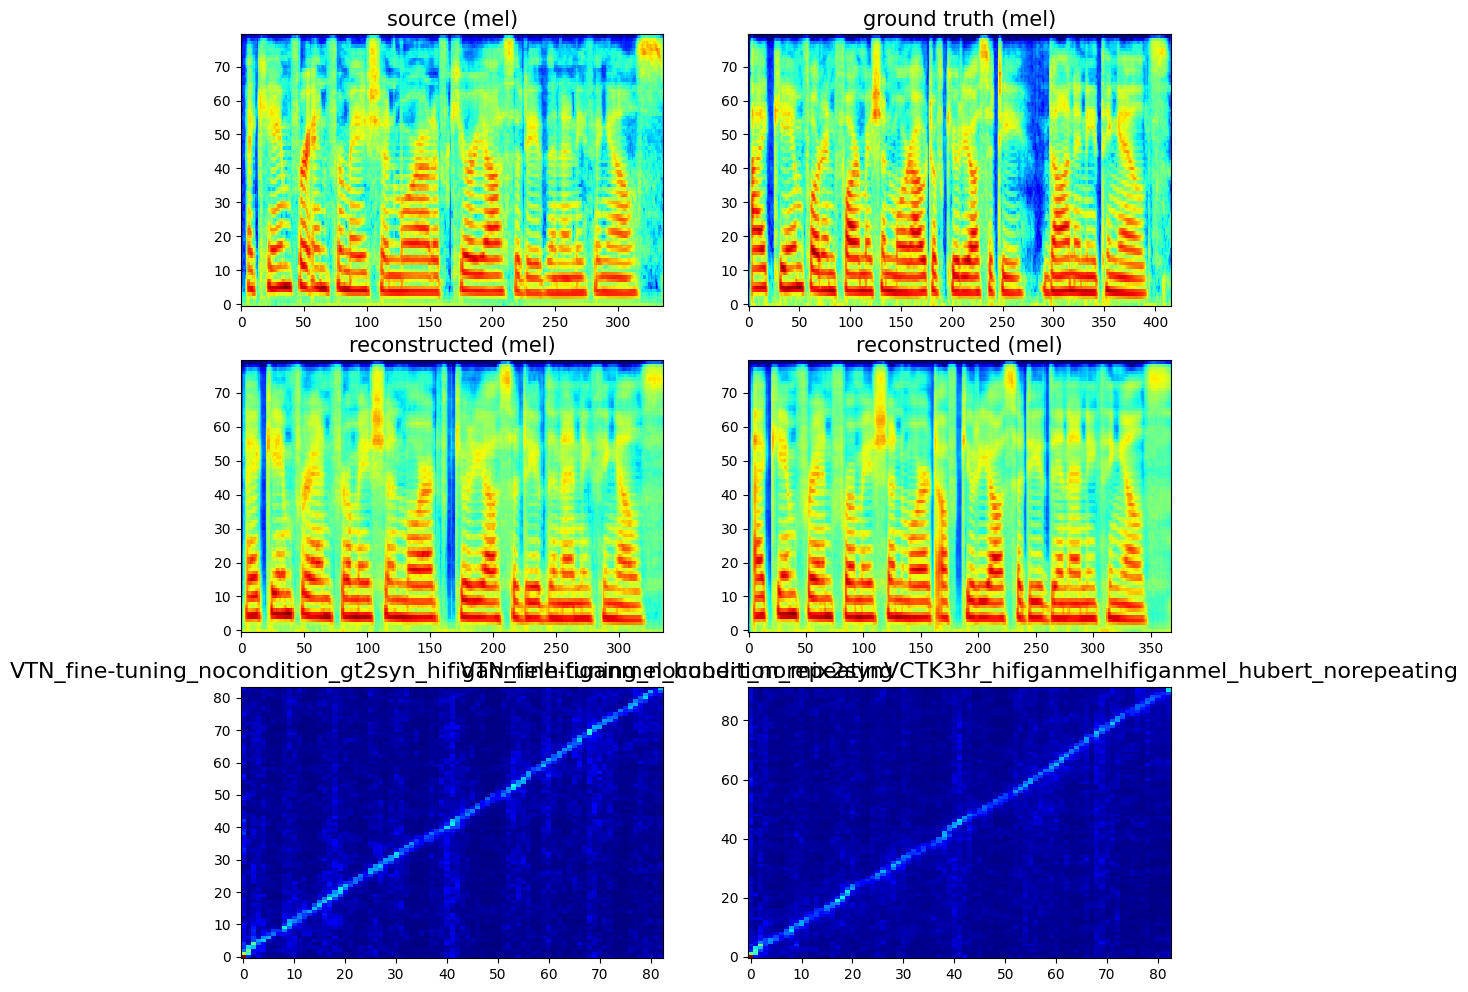

In [21]:
idx = 2
save = False
savedir = "test/vcsamples/"
if save:
    shutil.rmtree(savedir)
    os.makedirs(savedir)
with_steps = False
# fs = vocoder.model.h.sampling_rate
fs = 16000
for idx in [idx]:
# for idx in range(10):
    utt_id = dataset.files[idx]
    utt_basename = utt_id
    data = dataset[dataset.files.index(utt_id)]
    width = max(2, len(models))
    length = 3

    %matplotlib inline  
    fig = plt.figure(figsize=(6*width, 4*length))

    for m, config in enumerate(configlist):
        mn = os.path.basename(os.path.dirname(checkpoint_paths[m]))
        checkpoint = checkpoint_paths[m]
        steps = checkpoint.split("checkpoint-")[-1].split("steps")[0]
        outdir = config["outdir"] + steps + "/"
        label = labels[mn]
        if with_steps:
            label = label + "_" + steps

        if m==0:
            imelpath = os.path.join(outdir, "mel", f"input_{utt_basename}.npy")
            sourcemel = np.load(imelpath)
            sourcewav = vocoder.get(sourcemel)
            # sourcewav = sourcewav[0].numpy()

            gtmelpath = os.path.join(outdir, "mel", f"gt_{utt_basename}.npy")
            gtmel = np.load(gtmelpath)
            gtwav = vocoder.get(gtmel)
            # gtwav = gtwav[0].numpy()

            print("source")
            play_audio(sourcewav, fs)
            print("ground truth")
            play_audio(gtwav, fs)

            plot_spectrogram(sourcemel.T, fig, (length,width,1), title=f"source (mel)")
            plot_spectrogram(gtmel.T, fig, (length,width,2), title="ground truth (mel)")

            if save:
                savepath = savedir + f"{idx}_source.wav"
                write_wav(savepath, fs, sourcewav)
                savepath = savedir + f"{idx}_target.wav"
                write_wav(savepath, fs, gtwav)

        omelpath = os.path.join(outdir, "mel", f"output_{utt_basename}.npy")
        predmel = np.load(omelpath)
        # predmel = scaler["80mel"].transform(predmel)
        wavpath = os.path.join(outdir, "wav", f"{utt_basename}.wav")
        _, sr = torchaudio.load(wavpath)
        # predwav = predwav[0].numpy()
        predwav = vocoder.get(predmel)

        print(label)
        play_audio(predwav, sr)
        if save:
            savepath = savedir + f"{idx}_{label}.wav"
            sf.write(savepath, predwav, fs, "PCM_16")

        plot_spectrogram(predmel.T, fig, (length,width,width+m+1), title="reconstructed (mel)")

        probs = np.load(os.path.join(outdir, "probs", f"probs_{utt_basename}.npy"))
        attws = np.load(os.path.join(outdir, "att_ws", f"attws_{utt_basename}.npy"))
        att = np.array([attws[i][j] for i in range(attws.shape[0]) for j in range(attws.shape[1])]).mean(0)
        plot_spectrogram(att, fig, (length,width,2*width+m+1), title=label, title_font=16)
    if save:
        plt.savefig(f"{savedir}{idx}.png",  bbox_inches ="tight") 